# Modelling and simulations for Homogenized Material
## Heterogeneous Material
We consider a multilayer material of the type elastic-viscoelastic.
The general model for such type, the equation of motion and constitutive are give by:

\begin{equation}
\rho \partial_{tt} u - div( \sigma(u, \partial_{t} u)) = \mathbf{0}, \text{ in } \Omega
\end{equation}
\begin{equation}
\sigma(u, \partial_{t}u) = \mathbf{C}:\mathbf{e}(u) + \mathbf{D}:\mathbf{e}(\partial_{t}u), \text{ in } \Omega
\end{equation}

where the boundary conditions are defined on $\Sigma = \Gamma_D \cup \Gamma_N$ a (disjoint) partition of $\Omega$, are given in the mixed form:

\begin{equation}
\sigma (u, \partial_{t}u) \cdot n  = \mathbf{F}(t) \text{ on } \Gamma_N
\end{equation}
\begin{equation}
u(x,t) = \mathbf{0} \text{ on } \Gamma_N
\end{equation}

# Homogenized Material
Using the asymptotic homogenization technique (of order $\mathcal{O}(h^2)$). In this case, considering solutions of the form:

\begin{equation}
\hat{u} (x,\xi, p) = \sum_{a=0}^{\infty} \xi^a \hat{\bf{u}}^{(a)} (x,y,p)
\end{equation}

It's possible to deduce a *homogenized equation* where $\hat{\bf{v}}(x,p) = \hat{\bf{u}}^{(0)} (x,y,p)$, in the form:

\begin{equation}
\rho^{hom} p^2 \hat{\bf{v}} (x,p) - \nabla \cdot \sigma^{hom} (\hat{\bf{v}}) = \bf{0}
\end{equation}
\begin{equation}
\sigma^{hom}(\hat{\bf{v}}) = \big( \mathbf{C}^{hom} + p \mathbf{D}^{hom}\big) : \mathbf{e}(\hat{\bf{v}})
\end{equation}

where the *homogenized coefficients* or effective coeffs. are given by:

\begin{equation}
\mathbf{R}^{hom}_{ijrs} (p) = \bigg\langle \mathbf{R}_{ijrs} (y,p) + \mathbf{R}_{ijkl} (y,p) \mathbf{e}_{kl,y}(\bf{N}^{rs}(y,p)) \bigg\rangle
\end{equation}
with $R \in \{ \mathbf{C}, \mathbf{D} \}$.

In [2]:
# Obtain the experimental data from .mat file
import scipy.io as sio
import numpy as np
C_mathilde = sio.loadmat('Files_mat/C_values_mathilde.mat')
# Define the constants
# The stiffness constants in [GPa] --> [g/mm(\mu sec)^2]
# are given by the mathilde .mat (transverse isotropic)
C22_m = np.reshape(C_mathilde['C11'], (30,))#*1E-3
C12_m = np.reshape(C_mathilde['C12'], (30,))
C23_m = np.reshape(C_mathilde['C13'], (30,))#*1E-3
C33_m = np.reshape(C_mathilde['C33'], (30,))#*1E-3
C55_m = np.reshape(C_mathilde['C55'], (30,))#*1E-3
C66_m = np.reshape(C_mathilde['C66'], (30,))
# Obtain the density
d = np.reshape(C_mathilde['d'], (30,))#*1E-3
C_mathilde.keys()

dict_keys(['V_plaque', 'C11', 'C12', 'nu', 'VL_normal', 'VL_axial', 'C33', '__header__', '__globals__', 'VT', 'd', '__version__', 'C66', 'C55', 'C13'])

### Solution for the 2D cell problem (modified exacly to be as in P&G) by FEM

In [3]:
#%%writefile FunctionsCellProblems.py
# Main libraries to import
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
%matplotlib inline

# First, define important classes for the PDE problem
# Define a class for periodic boundary condition
# over the square mesh
class PeriodicBoundary(SubDomain):
    # Obtain the boundaries of the cube mesh
    def inside(self, x, on_boundary):
        height = near(x[1], a) or near(x[1], -a)
        length = near(x[0], a) or near(x[0], -a)
        bdry = height or length
        return bdry and on_boundary
    
    # Define mapping for periodicity
    def map(self, x, y):
        Top, Bottom = near(x[1], a), near(x[1], -a)
        Right, Left = near(x[0], a), near(x[0], -a)
        # Define periodicity for the Right--> Left boundary
        if Top:
            y[0] = x[0]
            y[1] = x[1] - 2*a
        # Define periodicity for the Up--> Down boundary
        elif Right:
            y[0] = x[0] - 2*a
            y[1] = x[1]
        # Map anyother point outside the boundary
        else:
            y[0] = 0.
            y[1] = 0.

# Define stiffness array C_{i,j,k,l} for 
# the transverse isotropic case
def VoigtToArray(A):
    # Upper diagonal
    A11, A12, A13, A14, A15, A16 = A[0,0], A[0,1], A[0,2], A[0,3], A[0,4], A[0,5]
    A22, A23, A24, A25, A26 = A[1,1], A[1,2], A[1,3], A[1,4], A[1,5]
    A33, A34, A35, A36 = A[2,2], A[2,3], A[2,4], A[2,5]
    A44, A45, A46 = A[3,3], A[3,4], A[3,5]
    A55, A56 = A[4,4], A[4,5]
    A66 = A[5,5]
    # Lower diagonal part (symmetric)
    A21 = A12
    A31, A32 = A13, A23
    A41, A42, A43 = A14, A24, A34
    A51, A52, A53, A54 = A15, A25, A35, A45
    A61, A62, A63, A64, A65 = A16, A26, A36, A46, A56
    
    return np.array([\
           [\
            [ [A11, A16, A15], [A16, A12, A14], [A15, A14, A13] ] ,\
            [ [A61, A66, A65], [A66, A62, A64], [A65, A64, A64] ] ,\
            [ [A51, A56, A55], [A56, A52, A54], [A55, A54, A53] ] \
           ], \
           [
            [ [A61, A66, A65], [A66, A62, A64], [A65, A64, A63] ] ,\
            [ [A21, A36, A25], [A26, A22, A24], [A25, A24, A23] ] ,\
            [ [A41, A46, A45], [A46, A42, A44], [A45, A44, A43] ] \
           ], \
           [
            [ [A51, A56, A55], [A56, A52, A54], [A55, A54, A53] ] ,\
            [ [A41, A46, A45], [A46, A42, A44], [A45, A44, A43] ] ,\
            [ [A31, A36, A35], [A36, A32, A34], [A35, A34, A33] ] \
           ] \
                     ])

# Define stiffness tensor C_{i,j,k,l} transverse isotropic
def VoigtToTensor(A):
    # Upper diagonal
    A11, A12, A13, A14, A15, A16 = A[0,0], A[0,1], A[0,2], A[0,3], A[0,4], A[0,5]
    A22, A23, A24, A25, A26 = A[1,1], A[1,2], A[1,3], A[1,4], A[1,5]
    A33, A34, A35, A36 = A[2,2], A[2,3], A[2,4], A[2,5]
    A44, A45, A46 = A[3,3], A[3,4], A[3,5]
    A55, A56 = A[4,4], A[4,5]
    A66 = A[5,5]
    # Lower diagonal part (symmetric)
    A21 = A12
    A31, A32 = A13, A23
    A41, A42, A43 = A14, A24, A34
    A51, A52, A53, A54 = A15, A25, A35, A45
    A61, A62, A63, A64, A65 = A16, A26, A36, A46, A56
    
    return as_tensor([\
           [\
            [ [A11, A16, A15], [A16, A12, A14], [A15, A14, A13] ] ,\
            [ [A61, A66, A65], [A66, A62, A64], [A65, A64, A64] ] ,\
            [ [A51, A56, A55], [A56, A52, A54], [A55, A54, A53] ] \
           ], \
           [
            [ [A61, A66, A65], [A66, A62, A64], [A65, A64, A63] ] ,\
            [ [A21, A36, A25], [A26, A22, A24], [A25, A24, A23] ] ,\
            [ [A41, A46, A45], [A46, A42, A44], [A45, A44, A43] ] \
           ], \
           [
            [ [A51, A56, A55], [A56, A52, A54], [A55, A54, A53] ] ,\
            [ [A41, A46, A45], [A46, A42, A44], [A45, A44, A43] ] ,\
            [ [A31, A36, A35], [A36, A32, A34], [A35, A34, A33] ] \
           ] \
                     ])


# Define stiffness tensor C_{i,j,r,s} 
# where the indices r,s are fixed
def VoigtToTensorContract2idx(A, r, s):
    # Obtain all 3x3 array elements at index r,s fixed
    # From VoigtToArray representation
    A11, A12, A13 = A[0,0,r,s], A[0,1,r,s], A[0,2,r,s]
    A21, A22, A23 = A[1,0,r,s], A[1,1,r,s], A[1,2,r,s]
    A31, A32, A33 = A[2,0,r,s], A[2,1,r,s], A[2,2,r,s]

    return as_tensor([\
                      [A11, A12, A13], \
                      [A21, A22, A23], \
                      [A31, A32, A33] \
                     ])
# Define useful constant
Zero = Constant(0.0)
# Define the strain tensor
def strain(N):
    E11, E12, E13 = N[0].dx(0), 0.5*(N[0].dx(1)+N[1].dx(0)), Zero
    E21, E22, E23 = 0.5*(N[1].dx(0)+N[0].dx(1)), N[1].dx(1), Zero
    E31, E32, E33 = 0.5*(N[2].dx(0)), 0.5*(N[2].dx(1)), Zero
    return as_tensor([\
                      [E11, E12, E13],\
                      [E21, E22, E23],\
                      [E31, E32, E33]\
                     ])
# Define 2D->3D partial derivatives tensor
def deriv3d(w):
    S11, S12, S13 = w[0].dx(0), w[0].dx(1), Zero
    S21, S22, S23 = w[1].dx(0), w[1].dx(1), Zero
    S31, S32, S33 = w[2].dx(0), w[2].dx(1), Zero
    return as_tensor([\
                      [S11, S12, S13],\
                      [S21, S22, S23],\
                      [S31, S32, S33]\
                     ])
# Define indices 
#i,j,k,l = indices(4)
# Define stress tensor
def sigma(N, R):
    """
    Input: N --> Solution to the cell problem and 
           R --> Tensor array being considered.
    """
    return as_tensor(R[i,j,k,l]*strain(N)[k,l], (i,j))

In [4]:
#%%writefile MainCellProblems.py
def CellProblemSol(mesh, C_matrix, C_marrow, porosity, structure, indexes,
                   epsilon, omega, save=False):
    """
    CellProblemSol computes the solution of the Cell problem by 
    FEM given as input a particular porosity and structure.

    Input parameters
    mesh: A mesh structure where the cell problem is defined.
    C_matrix: Voigt tensor material of bone matrix.
    C_marrow: Voigt tensor material of bone marrow.
    porosity: Value of porosity on the interval [0, 0.3].
    structure: 'Circular' or 'Rectangular'.
    indexes: Indexes to compute the homogenization procedure.
    epsilon: parameters for attenuation as dictionary (viscosity)
    omega: frequency associated to the model being considered.
    Output parameters ----COMPLETE!
    """
    global dx, ds, C, D
    # Define polynomial degrees
    pdim = 1
    # Define mixed function space and boundary conditions
    V = VectorElement("CG", mesh.ufl_cell(), degree=pdim, dim=3)
    V_elem = MixedElement([V, V])
    W = FunctionSpace(mesh, V_elem)
    # Define trial and test functions
    (N_R, N_I) = TrialFunctions(W)
    (w_R, w_I) = TestFunctions(W)
    
    # Define normal direction of mesh
    #n = FacetNormal(mesh)
    # Obtain the boundries
    bdries = MeshFunction("size_t", mesh, 
                          mesh.topology().dim()-1)
    # Define new measure for boundaries
    dx = dx(domain=mesh)
    ds = ds(domain=mesh, subdomain_data=bdries)
    
    # Define parameters for cell inclusion parameterization
    l = 0.0
    # Obtain the type of structure:
    if structure == 'Circular':
        # Here l is the radius^2 of the cilinder for cell
        l = porosity/np.pi
        C_jit = "(pow(x[0],2)+pow(x[1],2)<l)? Mw: Mb"
    elif structure == 'Rectangular':
        # If its a rectangular inclusion
        # Here l is the half length of inclusion for cell
        l = np.sqrt(porosity)/2
        C_jit = "(std::abs(x[0])<l && std::abs(x[1])<l) \
                 ? Mw: Mb"
    else:
        raise ValueError('Just two type of structures suppported.')
    
    # Assign attenuation values at each component
    eps_b = epsilon['epsilon_b'] # Attenuation on matrix
    eps_w = epsilon['epsilon_w'] # Attenuation on marrow
    
    # Create expressions for voigt C_{ij} elastic coeffs.
    C11 = Expression(C_jit, degree=pdim,
                     Mb=C_matrix[0,0], Mw=C_marrow[0,0], l=l)
    C12 = Expression(C_jit, degree=pdim,
                     Mb=C_matrix[0,1], Mw=C_marrow[0,1], l=l)
    C22 = Expression(C_jit, degree=pdim,
                     Mb=C_matrix[1,1], Mw=C_marrow[1,1], l=l)
    C13 = Expression(C_jit, degree=pdim,
                     Mb=C_matrix[0,2], Mw=C_marrow[0,2], l=l)
    C23 = Expression(C_jit, degree=pdim,
                     Mb=C_matrix[1,2], Mw=C_marrow[1,2], l=l)
    C33 = Expression(C_jit, degree=pdim,
                     Mb=C_matrix[2,2], Mw=C_marrow[2,2], l=l)
    C44 = Expression(C_jit, degree=pdim,
                     Mb=C_matrix[3,3], Mw=C_marrow[3,3], l=l)
    C55 = Expression(C_jit, degree=pdim,
                     Mb=C_matrix[4,4], Mw=C_marrow[4,4], l=l)
    C66 = Expression(C_jit, degree=pdim,
                     Mb=C_matrix[5,5], Mw=C_marrow[5,5], l=l)
    
    # Create expressions for voigt viscous D_{ij} coeffs.
    D11 = Expression(C_jit, degree=pdim,
                     Mb=eps_b*C_matrix[0,0], Mw=eps_w*C_marrow[0,0], l=l)
    D12 = Expression(C_jit, degree=pdim,
                     Mb=eps_b*C_matrix[0,1], Mw=eps_w*C_marrow[0,1], l=l)
    D22 = Expression(C_jit, degree=pdim,
                     Mb=eps_b*C_matrix[1,1], Mw=eps_w*C_marrow[1,1], l=l)
    D13 = Expression(C_jit, degree=pdim,
                     Mb=eps_b*C_matrix[0,2], Mw=eps_w*C_marrow[0,2], l=l)
    D23 = Expression(C_jit, degree=pdim,
                     Mb=eps_b*C_matrix[1,2], Mw=eps_w*C_marrow[1,2], l=l)
    D33 = Expression(C_jit, degree=pdim,
                     Mb=eps_b*C_matrix[2,2], Mw=eps_w*C_marrow[2,2], l=l)
    D44 = Expression(C_jit, degree=pdim,
                     Mb=eps_b*C_matrix[3,3], Mw=eps_w*C_marrow[3,3], l=l)
    D55 = Expression(C_jit, degree=pdim,
                     Mb=eps_b*C_matrix[4,4], Mw=eps_w*C_marrow[4,4], l=l)
    D66 = Expression(C_jit, degree=pdim,
                     Mb=eps_b*C_matrix[5,5], Mw=eps_w*C_marrow[5,5], l=l)
    # Construct the voigt matrix representation
    # For the elasticity tensor
    C_voigt = np.array([\
                    [C11, C12, C13, 0, 0, 0], \
                    [C12, C22, C23, 0, 0, 0], \
                    [C13, C23, C33, 0, 0, 0], \
                    [0, 0, 0, C44, 0, 0], \
                    [0, 0, 0, 0, C55, 0], \
                    [0, 0, 0, 0, 0, C66] \
                       ])
    # For the viscosity tensor
    D_voigt = np.array([\
                    [D11, D12, D13, 0, 0, 0], \
                    [D12, D22, D23, 0, 0, 0], \
                    [D13, D23, D33, 0, 0, 0], \
                    [0, 0, 0, D44, 0, 0], \
                    [0, 0, 0, 0, D55, 0], \
                    [0, 0, 0, 0, 0, D66] \
                       ])
    # Obtain the C and D in tensor representation    
    C = VoigtToTensor(C_voigt)
    D = VoigtToTensor(D_voigt)
    # The rhs block A_block is defined for fixed indexes r,s
    def A_block(N, w, R):
        # Receives R as a fourth rank tensor
        return (sigma(N, R)[i,j]*w[i].dx(j))*dx
    # In the B_block, we fix indexes r,s
    def B_block(w, r, s, R_voigt):
        # Obtain array for indexes r,s
        R_array = VoigtToArray(R_voigt)
        # Compute tensor fixing r,s indexes 
        R_ct = VoigtToTensorContract2idx(R_array,r,s)
        return -(R_ct[i,j]*deriv3d(w)[i,j])*dx
        
    # Define boundary conditions
    #jit_ext = "(near(x[0], -0.5) || near(x[0], 0.5) || \
    #           near(x[1], -0.5) || near(x[1], 0.5)) && on_boundary"
    bc_ext_C = DirichletBC(W.sub(0), Constant(3*(0.,)), "on_boundary")
    bc_ext_D = DirichletBC(W.sub(1), Constant(3*(0.,)), "on_boundary")
    # List boundary conditions
    bcs = [bc_ext_C, bc_ext_D]
    
    # Create Krylov solver 
    solver = PETScKrylovSolver("gmres", "ilu")
    solver.parameters["absolute_tolerance"] = 1E-7
    solver.parameters["maximum_iterations"] = 2000
    solver.parameters["monitor_convergence"] = False
    
    # Define solution for the variational formulation
    N_sol = Function(W)
    # Save coeffs of tensor as 4d array
    C_array = np.zeros((3,3,3,3))
    D_array = np.zeros((3,3,3,3))
    # Save coeffs of Q-factor decomposition
    IQ_lin = np.zeros_like(C_array)
    IQ_nlin = np.zeros_like(C_array)
    # Iterate over indexes
    for id_i, id_j, r, s in indexes:
        # Variational forms associated to the real and imaginary parts
        A_lhs_R = A_block(N_R, w_R, C) - \
                  Constant(omega)*A_block(N_I, w_R, D)
        A_lhs_I = A_block(N_I, w_I, C) + \
                  Constant(omega)*A_block(N_R, w_I, D)
        # Compute rhs associated to both (real and imag parts)
        b_rhs_R = B_block(w_R, r, s, C_voigt)
        b_rhs_I = Constant(omega)*B_block(w_I, r, s, D_voigt)
        
        # Assemble of matrices
        A = assemble(A_lhs_R+A_lhs_I)
        b = assemble(b_rhs_R+b_rhs_I)
        # Apply boundary conditions for both problems
        [bc.apply(A, b) for bc in bcs]
        
        # Create vector that spans the null space
        null_vec = Vector(N_sol.vector())
        W.dofmap().set(null_vec, 1.0)
        null_vec *= 1.0/null_vec.norm("l2")
        # Create null space basis object and atach 
        # to PERTSc matrix
        null_space = VectorSpaceBasis([null_vec])
        as_backend_type(A).set_nullspace(null_space)
        # Ortogonalize b with respect to the null space
        null_space.orthogonalize(b)
        # Add A matrix representation to Krylov solver
        solver.set_operator(A)
        # Solve the variational problem
        solver.solve(N_sol.vector(), b)
        
        # Split solution in real and imag parts
        (sol_R, sol_I) = N_sol.split(True)

        # If selected, save solutions
        # ADD SAVING FOR VISCOUS SOLUTIONS!!!!
        #if save and (r,s) == (0,0):
            #str_idx = str(id_i)+str(id_j)+str(r)+str(s)
            #file_to_save ="Results/CellProblems/CellProblemsol3D_idx"+\
            #              str_idx+"Por"+str(porosity)+".pvd"
            #File(file_to_save) << N_sol
        
        
        # Compute homogenized coefficient
        C_elem = assemble(C[id_i,id_j,r,s]*dx)
        D_elem = assemble(D[id_i,id_j,r,s]*dx)
        # Obs: We are considering the decomposition given by
        # C^hom + i \omega D^hom
        C_sgm = assemble(sigma(sol_R, C)[id_i,id_j]*dx) - \
                assemble(sigma(sol_I, D)[id_i,id_j]*dx)*omega
        D_sgm = assemble(sigma(sol_I, C)[id_i,id_j]*dx)*pow(omega,-1) + \
                assemble(sigma(sol_R, D)[id_i,id_j]*dx)
        C_array[id_i,id_j,r,s] = C_elem+C_sgm
        D_array[id_i,id_j,r,s] = D_elem+D_sgm
        # Define inverse of Q-factor coefficient (Re/Im part)
        # by computing its linear and linear parts
        # First, its linear part!
        IQ_lin[id_i,id_j,r,s] = D_elem/C_elem
        # Now, the nonlinear one!
        aux = C_elem*(C_elem+C_sgm)
        IQ_nlin[id_i,id_j,r,s] = (C_elem*(D_elem+D_sgm)-D_elem*(C_elem+C_sgm))/aux
        
        # FOR TESTING!!
        print("""
              At indexes: ({0},{1},{2},{3}) 
              The hom. coeff. C: {4:.4f}
              The hom. coeff. D: {5:.4f}
              IQ (Linear, NonLinear) --> {6:.4f}, {7:.4f}
              """.format(id_i,id_j,r,s,
                         C_array[id_i,id_j,r,s],
                         D_array[id_i,id_j,r,s],
                         IQ_lin[id_i,id_j,r,s],
                         IQ_nlin[id_i,id_j,r,s]))
    
    # Return the array
    return C_array, D_array, IQ_lin, IQ_nlin

### Compute homogenized coeffs. for the rectangular inclusion
For the stabble coefficients $C_{22}, C_{33}, C_{23}$

In [5]:
# Problem solution for testing
set_log_level(ERROR)
part = 50 # Number of partitions
# Create box corresponding to the microstructure
box_mesh = RectangleMesh(Point(-0.5,-0.5),Point(0.5,0.5),
                         part, part)
"""
# Refine box mesh twice
for _ in range(1):
    # First mark all cells
    cell_markers = MeshFunction("bool", box_mesh, 3)
    cell_markers.set_all(False)
    # assign a different mark for the some cells
    for cell in cells(box_mesh):
        p = cell.midpoint()
        if np.abs(p.x()) < 0.15 and np.abs(p.y()) < 0.15:
            cell_markers[cell] = True

    # Refine over the interest domain
    box_mesh = refine(box_mesh, cell_markers, redistribute=True)
"""

# Define parameters of length "a" for box mesh
a = 0.5 # Fixed!
print("""
      Minimum height of element [mm]: {0:.5f};
      Number Cells; {1}, Vertice: {2}
      """.format(box_mesh.hmin(),
                 box_mesh.num_cells(), 
                 box_mesh.num_vertices()))
# Test for PETSc
if not has_linear_algebra_backend("PETSc"):
    print(" Not configured PETSc compiling ")
    
# Define the Voigt matrix stiffness representation
# for material Mb: bone
Mb = np.array([\
               [26.8, 15.2, 15.3, 0, 0, 0], \
               [15.2, 26.8, 15.3, 0, 0, 0], \
               [15.3, 15.3, 35.1, 0, 0, 0], \
               [0, 0, 0, 7.3, 0, 0], \
               [0, 0, 0, 0, 7.3, 0], \
               [0, 0, 0, 0, 0, 5.8]
              ]) 
# for material Mw: water
Mw = np.array([\
               [2.0537, 1.9732, 1.9732, 0, 0, 0], \
               [1.9732, 2.0537, 1.9732, 0, 0, 0], \
               [1.9732, 1.9732, 2.0537, 0, 0, 0], \
               [0, 0, 0, 0.0468, 0, 0], \
               [0, 0, 0, 0, 0.0468, 0], \
               [0, 0, 0, 0, 0, 0.0468], \
              ])
# Define an array of porosities
porosities = np.arange(0.01, 0.31, step=0.01)
Npor = len(porosities)
## Let us check for the case Rectangular
structure = 'Circular'
#structure = 'Rectangular'
# Define the array of homogenized coeffs
C_hom = np.zeros((3,3,3,3,Npor))
D_hom = np.zeros_like(C_hom)
IQ_lin_hom = np.zeros_like(C_hom)
IQ_nlin_hom = np.zeros_like(C_hom)
# Indexes will be given only main coeffs
indexes = [(0,0,0,0), (0,0,1,1), (0,1,0,1),
           (2,2,2,2), (1,1,2,2), (1,2,1,2)]
saved = False
# Amount of attenuation for our model
epsilon = {'epsilon_b': 5E-2, 'epsilon_w': 1E-3}
# Radial frequency associated to the simulation
omega = 0.5 # in [Mhz]
# Iterate over the porosities
for phi in range(Npor):
    try:
        if porosities[phi] in [0.05, 0.15, 0.2]:
            saved = False
        else:
            saved = False
        # Solve cell problems
        print("At porosity: ", porosities[phi])
        C_array, D_array, IQ_lin_array, IQ_nlin_array = CellProblemSol(box_mesh, Mb, Mw, 
                                                                   porosities[phi], structure, indexes,
                                                                   epsilon, omega, save=saved)
        C_hom[:,:,:,:,phi] = C_array
        D_hom[:,:,:,:,phi] = D_array
        IQ_lin_hom[:,:,:,:,phi] = IQ_lin_array
        IQ_nlin_hom[:,:,:,:,phi] = IQ_nlin_array
        
    except RuntimeError:
        print('Failed at porosity: ', porosities[phi])
        break



      Minimum height of element [mm]: 0.02828;
      Number Cells; 5000, Vertice: 2601
      
At porosity:  0.01

              At indexes: (0,0,0,0) 
              The hom. coeff. C: 26.2363
              The hom. coeff. D: 1.3034
              IQ (Linear, NonLinear) --> 0.0500, -0.0003
              

              At indexes: (0,0,1,1) 
              The hom. coeff. C: 14.8359
              The hom. coeff. D: 0.7337
              IQ (Linear, NonLinear) --> 0.0499, -0.0005
              

              At indexes: (0,1,0,1) 
              The hom. coeff. C: 5.6995
              The hom. coeff. D: 0.2848
              IQ (Linear, NonLinear) --> 0.0500, -0.0000
              

              At indexes: (2,2,2,2) 
              The hom. coeff. C: 34.6724
              The hom. coeff. D: 1.7285
              IQ (Linear, NonLinear) --> 0.0500, -0.0001
              

              At indexes: (1,1,2,2) 
              The hom. coeff. C: 14.9744
              The hom. coeff. D: 0.7423
    


              At indexes: (0,0,0,0) 
              The hom. coeff. C: 21.8488
              The hom. coeff. D: 1.0281
              IQ (Linear, NonLinear) --> 0.0497, -0.0026
              

              At indexes: (0,0,1,1) 
              The hom. coeff. C: 11.9381
              The hom. coeff. D: 0.5342
              IQ (Linear, NonLinear) --> 0.0495, -0.0047
              

              At indexes: (0,1,0,1) 
              The hom. coeff. C: 4.8950
              The hom. coeff. D: 0.2438
              IQ (Linear, NonLinear) --> 0.0500, -0.0002
              

              At indexes: (2,2,2,2) 
              The hom. coeff. C: 31.2478
              The hom. coeff. D: 1.5217
              IQ (Linear, NonLinear) --> 0.0498, -0.0011
              

              At indexes: (1,1,2,2) 
              The hom. coeff. C: 12.4176
              The hom. coeff. D: 0.5704
              IQ (Linear, NonLinear) --> 0.0495, -0.0035
              

              At indexes: (1,2,1,2) 
        


              At indexes: (0,1,0,1) 
              The hom. coeff. C: 4.2714
              The hom. coeff. D: 0.2122
              IQ (Linear, NonLinear) --> 0.0499, -0.0002
              

              At indexes: (2,2,2,2) 
              The hom. coeff. C: 28.1406
              The hom. coeff. D: 1.3453
              IQ (Linear, NonLinear) --> 0.0495, -0.0017
              

              At indexes: (1,1,2,2) 
              The hom. coeff. C: 10.4211
              The hom. coeff. D: 0.4461
              IQ (Linear, NonLinear) --> 0.0489, -0.0061
              

              At indexes: (1,2,1,2) 
              The hom. coeff. C: 5.4484
              The hom. coeff. D: 0.2714
              IQ (Linear, NonLinear) --> 0.0499, -0.0001
              
At porosity:  0.16

              At indexes: (0,0,0,0) 
              The hom. coeff. C: 17.9049
              The hom. coeff. D: 0.7978
              IQ (Linear, NonLinear) --> 0.0493, -0.0047
              

              At indexes: (


              At indexes: (2,2,2,2) 
              The hom. coeff. C: 25.3453
              The hom. coeff. D: 1.1926
              IQ (Linear, NonLinear) --> 0.0492, -0.0021
              

              At indexes: (1,1,2,2) 
              The hom. coeff. C: 8.8689
              The hom. coeff. D: 0.3546
              IQ (Linear, NonLinear) --> 0.0483, -0.0083
              

              At indexes: (1,2,1,2) 
              The hom. coeff. C: 4.7241
              The hom. coeff. D: 0.2348
              IQ (Linear, NonLinear) --> 0.0499, -0.0002
              
At porosity:  0.23

              At indexes: (0,0,0,0) 
              The hom. coeff. C: 15.3998
              The hom. coeff. D: 0.6598
              IQ (Linear, NonLinear) --> 0.0489, -0.0061
              

              At indexes: (0,0,1,1) 
              The hom. coeff. C: 7.7792
              The hom. coeff. D: 0.2815
              IQ (Linear, NonLinear) --> 0.0482, -0.0120
              

              At indexes: (0


              At indexes: (1,1,2,2) 
              The hom. coeff. C: 7.6865
              The hom. coeff. D: 0.2881
              IQ (Linear, NonLinear) --> 0.0475, -0.0101
              

              At indexes: (1,2,1,2) 
              The hom. coeff. C: 4.1118
              The hom. coeff. D: 0.2040
              IQ (Linear, NonLinear) --> 0.0499, -0.0003
              
At porosity:  0.3

              At indexes: (0,0,0,0) 
              The hom. coeff. C: 13.3396
              The hom. coeff. D: 0.5504
              IQ (Linear, NonLinear) --> 0.0484, -0.0072
              

              At indexes: (0,0,1,1) 
              The hom. coeff. C: 6.5615
              The hom. coeff. D: 0.2145
              IQ (Linear, NonLinear) --> 0.0474, -0.0147
              

              At indexes: (0,1,0,1) 
              The hom. coeff. C: 3.2648
              The hom. coeff. D: 0.1615
              IQ (Linear, NonLinear) --> 0.0498, -0.0004
              

              At indexes: (2,2

## Plots of the Linearity and Nonlinearity

In [6]:
# Save data in pickle format
import pickle, io
# Define data to save
data_save = {'structure': structure, 
             'MinHeigth': box_mesh.hmin(),
             'NumCells': box_mesh.num_cells(),
             'NumVerts': box_mesh.num_vertices(),
             'C22': list(C_hom[0,0,0,0,:]),# Elastic Coeffs
             'C66': list(C_hom[0,1,0,1,:]),
             'C33': list(C_hom[2,2,2,2,:]),
             'C23': list(C_hom[1,1,2,2,:]),
             'C55': list(C_hom[1,2,1,2,:]),
             'C12': list(C_hom[0,0,1,1,:]),
             'D22': list(D_hom[0,0,0,0,:]),# Viscous Coeffs
             'D66': list(D_hom[0,1,0,1,:]),
             'D33': list(D_hom[2,2,2,2,:]),
             'D23': list(D_hom[1,1,2,2,:]),
             'D55': list(D_hom[1,2,1,2,:]),
             'D12': list(D_hom[0,0,1,1,:]),
             'IQ_lin_22': list(IQ_lin_hom[0,0,0,0,:]),# Linear Part Q^{-1}
             'IQ_lin_66': list(IQ_lin_hom[0,1,0,1,:]),
             'IQ_lin_33': list(IQ_lin_hom[2,2,2,2,:]),
             'IQ_lin_23': list(IQ_lin_hom[1,1,2,2,:]),
             'IQ_lin_55': list(IQ_lin_hom[1,2,1,2,:]),
             'IQ_lin_12': list(IQ_lin_hom[0,0,1,1,:]),
             'IQ_nlin_22': list(IQ_nlin_hom[0,0,0,0,:]),# Nonlinear Part Q^{-1}
             'IQ_nlin_66': list(IQ_nlin_hom[0,1,0,1,:]),
             'IQ_nlin_33': list(IQ_nlin_hom[2,2,2,2,:]),
             'IQ_nlin_23': list(IQ_nlin_hom[1,1,2,2,:]),
             'IQ_nlin_55': list(IQ_nlin_hom[1,2,1,2,:]),
             'IQ_nlin_12': list(IQ_nlin_hom[0,0,1,1,:])
            }
# Define output file
output = 'DataPICKLE/Visc_'+str(structure)+'2DPart'+ \
         str(part)+'EPS5-2_Ome'+str(omega)+'.pickle'
with io.open(output, 'wb') as handle:
    pickle.dump(data_save, handle, 
               protocol=pickle.HIGHEST_PROTOCOL)

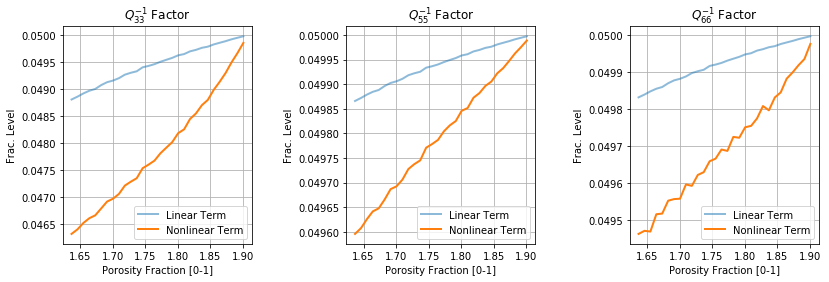

In [21]:
import pickle, io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# First, Obtain the structure
structure = 'Circular'
#structure = 'Rectangular'
# Obtain porosity arrange
porosities = np.arange(0.01, 0.31, step=0.01)
# Now, create the plot figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
fig.subplots_adjust(left=0.2, wspace=0.5)
# Define legend label
legend_name = []
# Obtain the mesh partition, fixed!
part = 50
# Iterate over the files
for value in [0.5]:
    filename = 'DataPICKLE/Visc_'+str(structure)+'2DPart'+\
                str(part)+'EPS5-2_Ome'+str(value)+'.pickle'
    with open(filename, 'rb') as handle:
        data_saved = pickle.load(handle)
    # plot the case of Inverse Q_33
    ax[0].plot(d, IQ_lin_hom[2,2,2,2,:], 
               linewidth=2, alpha=0.5)
    full_33 = IQ_lin_hom[2,2,2,2,:]+IQ_nlin_hom[2,2,2,2,:]
    ax[0].plot(d, full_33,
               linewidth=2)
    # Now, for the case inverse Q_44 = Q_55
    ax[1].plot(d, IQ_lin_hom[1,2,1,2,:], 
               linewidth=2, alpha=0.5)
    full_55 = IQ_lin_hom[1,2,1,2,:]+IQ_nlin_hom[1,2,1,2,:]
    ax[1].plot(d, full_55,
               linewidth=2)
    # Finally, case of inverse Q_66
    ax[2].plot(d, IQ_lin_hom[0,1,0,1,:], 
               linewidth=2, alpha=0.5)
    full_66 = IQ_lin_hom[0,1,0,1,:]+IQ_nlin_hom[0,1,0,1,:]
    ax[2].plot(d, full_66, 
               linewidth=2)
    legend_name.append('Linear Term')
    legend_name.append('Nonlinear Term')
# Add more formating to the plot.
for n in range(0,3):
    if n == 0:
        ax[n].set_title('$Q^{-1}_{33}$ Factor')
    elif n == 1:
        ax[n].set_title('$Q^{-1}_{55}$ Factor')
    else:
        ax[n].set_title('$Q^{-1}_{66}$ Factor')
    
    # set ylabel at each case
    ax[n].set_ylabel('Frac. Level')
    # Mark the other options for the figure
    #ax[n].set_xlabel('Density $[g\, cm^{3}]$')
    ax[n].set_xlabel('Porosity Fraction [0-1]')
    #ax[n].set_xlim([0.0, 0.3])
    # Add legend
    ax[n].legend(legend_name, loc='best')
    ax[n].grid()
# save it!
filename = 'Plots/PlotsVisc_'+str(structure)+'2DPart'+\
            str(part)+'EPS5-2_Ome'+str(omega)
for _ in ['.pdf', '.png']:
    plt.savefig(filename+_, dpi=150, bbox_inches='tight')
# show plot
plt.show()

## Plot relations between $C_{ijkl}$ and $Q^{-1}_{ijkl}$

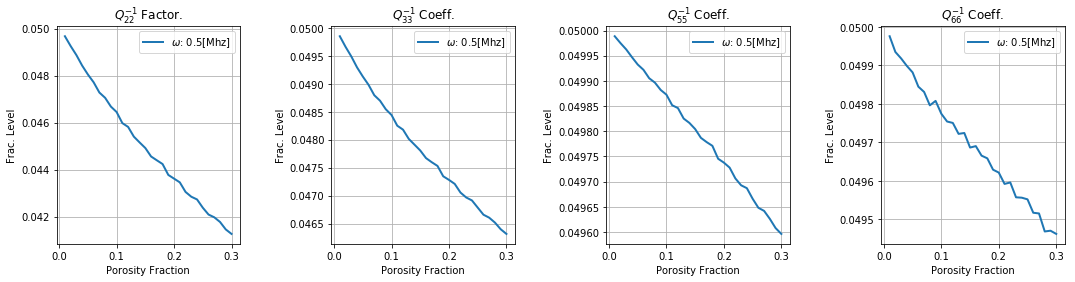

In [6]:
import pickle, io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# First, Obtain the structure
structure = 'Circular'
#structure = 'Rectangular'
# Obtain porosity arrange
porosities = np.arange(0.01, 0.31, step=0.01)
# Radial frequency associated to the simulation
omega = 0.5 # in [Mhz]
# Now, create the plot figure
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,4))
fig.subplots_adjust(left=0.2, wspace=0.5)
# Define legend label
legend_name = []
# Obtain the mesh partition, fixed!
part = 50
for value in [0.5]:
    filename = 'DataPICKLE/Visc_'+str(structure)+'2DPart'+\
                str(part)+'EPS5-2_Ome'+str(omega)+'.pickle'
    legend_name.append('$\omega$: '+str(value)+'[Mhz]')
    with open(filename, 'rb') as handle:
        data_saved = pickle.load(handle)
    # Now, plot the case of Inverse Q_22
    IQ_22 = np.array(data_saved['D22'])/\
            np.array(data_saved['C22'])
    ax[0].plot(porosities, IQ_22, linewidth=2)
    # plot the case of Inverse Q_33
    IQ_33 = np.array(data_saved['D33'])/\
            np.array(data_saved['C33'])
    ax[1].plot(porosities, IQ_33, linewidth=2)
    # Now, for the case inverse Q_44 = Q_55
    IQ_55 = np.array(data_saved['D55'])/\
            np.array(data_saved['C55'])
    ax[2].plot(porosities, IQ_55, linewidth=2)
    # Finally, case of inverse Q_66
    IQ_66 = np.array(data_saved['D66'])/\
            np.array(data_saved['C66'])
    ax[3].plot(porosities, IQ_66, linewidth=2)
    
# Add more formating to the plot.
for n in range(0,4):
    if n == 0:
        ax[n].set_title('$Q^{-1}_{22}$ Factor.')
    elif n == 1:
        ax[n].set_title('$Q^{-1}_{33}$ Coeff.')
    elif n == 2:
        ax[n].set_title('$Q^{-1}_{55}$ Coeff.')
    else:
        ax[n].set_title('$Q^{-1}_{66}$ Coeff.')
    
    # set ylabel at each case
    ax[n].set_ylabel('Frac. Level')
    # Mark the other options for the figure
    #ax[n].set_xlabel('Density $[g\, cm^{3}]$')
    ax[n].set_xlabel('Porosity Fraction')
    #ax[n].set_xlim([0.0, 0.3])
    # Add legend
    ax[n].legend(legend_name, loc='best')
    ax[n].grid()
# save it!
#filename = 'Plots/CellProb_Qfactor'+str(structure)+\
#           'E-3.png'
#plt.savefig(filename, dpi=150, bbox_inches='tight')
# show plot
plt.show()

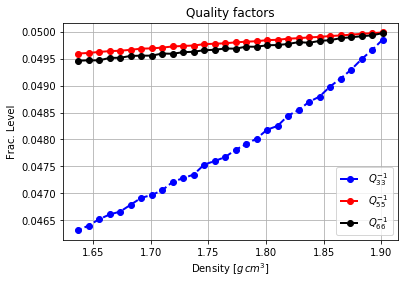

In [7]:
plt.title("Quality factors")
plt.plot(d, np.array(data_saved['D33'])/np.array(data_saved['C33']), 
         'bo--', linewidth=2)
plt.plot(d, np.array(data_saved['D55'])/np.array(data_saved['C55']),
         'ro--', linewidth=2)
plt.plot(d, np.array(data_saved['D66'])/np.array(data_saved['C66']),
         'ko--',linewidth=2)
plt.legend(["$Q_{33}^{-1}$","$Q_{55}^{-1}$","$Q_{66}^{-1}$"])
plt.xlabel("Density $[g \, cm^{3}]$")
plt.ylabel("Frac. Level")
plt.grid()

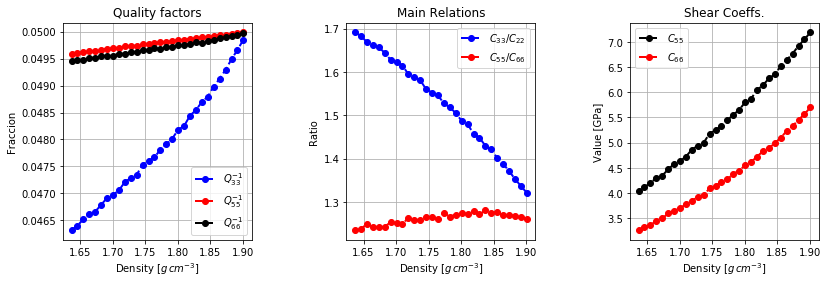

In [8]:
# Create the plot figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
fig.subplots_adjust(left=0.2, wspace=0.5)
# Define legend label
legend_name = []
# Obtain the mesh partition, fixed!
part = 50
# Iterate over the files
# plot the case of Inverse Q_33
IQ_33 = np.array(data_saved['D33'])/\
        np.array(data_saved['C33'])
ax[0].plot(d, IQ_33, 'bo--' ,linewidth=2)
# Now, for the case inverse Q_44 = Q_55
IQ_55 = np.array(data_saved['D55'])/\
        np.array(data_saved['C55'])
ax[0].plot(d, IQ_55, 'ro--', linewidth=2)
# Finally, case of inverse Q_66
IQ_66 = np.array(data_saved['D66'])/\
        np.array(data_saved['C66'])
ax[0].plot(d, IQ_66, 'ko--', linewidth=2)

# plot the elasctic coefficients also
Ratio_3311 = np.array(data_saved['C33'])/\
             np.array(data_saved['C22'])
ax[1].plot(d, Ratio_3311, 'bo--', linewidth=2)

Ratio_5566 = np.array(data_saved['C55'])/\
             np.array(data_saved['C66'])
ax[1].plot(d, Ratio_5566, 'ro--', linewidth=2)

# Plot other coeffs for comparison with Bernard et al. 2015
ax[2].plot(d, np.array(data_saved['C55']), 'ko--', linewidth=2)
ax[2].plot(d, np.array(data_saved['C66']), 'ro--', linewidth=2)


# Add more formating to the plot.
# set ylabel at each case
ax[0].set_ylabel('Fraccion')
ax[1].set_ylabel('Ratio')
ax[2].set_ylabel('Value [GPa]')
# Mark the other options for the figure
ax[0].set_xlabel('Density $[g\, cm^{-3}]$')
ax[1].set_xlabel('Density $[g\, cm^{-3}]$')
ax[2].set_xlabel('Density $[g\, cm^{-3}]$')
# Give titles to the plots
ax[0].set_title('Quality factors')
ax[1].set_title('Main Relations')
ax[2].set_title('Shear Coeffs.')

# Add legend
ax[0].legend(["$Q_{33}^{-1}$","$Q_{55}^{-1}$","$Q_{66}^{-1}$"], 
             loc='best')
ax[1].legend(["$C_{33}/C_{22}$","$C_{55}/C_{66}$"], 
             loc='best')
ax[2].legend(['$C_{55}$', '$C_{66}$'], loc='best')

ax[0].grid()
ax[1].grid()
ax[2].grid()
# save it!
filename = 'Plots/CellProb_Qfactor'+str(structure)+\
           '5E-2_Relations'
for _ in ['.pdf', 'png']:
    plt.savefig(filename+_, dpi=150, bbox_inches='tight')
# show plot
plt.show()

### Easy Plotting function and comparison

In [10]:
def QFactorPlot(data_saved, eps_factor):
    # Create the plot figure
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    fig.subplots_adjust(left=0.2, wspace=0.5)
    # Define legend label
    legend_name = []
    # Obtain the mesh partition, fixed!
    part = 50
    # Iterate over the files
    # plot the case of Inverse Q_33
    IQ_33 = np.array(data_saved['D33'])/\
            np.array(data_saved['C33'])
    ax[0].plot(d, IQ_33, 'bo--' ,linewidth=2)
    # Now, for the case inverse Q_44 = Q_55
    IQ_55 = np.array(data_saved['D55'])/\
            np.array(data_saved['C55'])
    ax[0].plot(d, IQ_55, 'ro--', linewidth=2)
    # Finally, case of inverse Q_66
    IQ_66 = np.array(data_saved['D66'])/\
            np.array(data_saved['C66'])
    ax[0].plot(d, IQ_66, 'ko--', linewidth=2)

    # plot the elasctic coefficients also
    EC_33 = np.array(data_saved['C33'])
    ax[1].plot(d, EC_33, 'bo--', linewidth=2)
    EC_55 = np.array(data_saved['C55'])
    ax[1].plot(d, EC_55, 'ro--', linewidth=2)
    EC_66 = np.array(data_saved['C66'])
    ax[1].plot(d, EC_66, 'ko--', linewidth=2)
    # Add more formating to the plot.
    # set ylabel at each case
    ax[0].set_ylabel('Fraccion')
    ax[1].set_ylabel('[GPa]')
    # Mark the other options for the figure
    ax[0].set_xlabel('Density $[g\, cm^{3}]$')
    ax[1].set_xlabel('Density $[g\, cm^{3}]$')
    # Give titles to the plots
    ax[0].set_title('Q factor with '+ att)
    ax[1].set_title('Elastic Coeffs')
    # Add legend
    ax[0].legend(["$Q_{33}^{-1}$","$Q_{55}^{-1}$","$Q_{66}^{-1}$"], 
                 loc='best')
    ax[1].legend(["$C_{33}$","$C_{55}$","$C_{66}$"], 
                 loc='best')
    ax[0].grid()
    ax[1].grid()
    # save it!
    filename = 'Plots/CellProb_QfactorEPS'+str(eps_factor)
    for _ in ['.pdf', '.png']:
        plt.savefig(filename+_, dpi=150, bbox_inches='tight')
    # show plot
    plt.show()
    return fig, ax

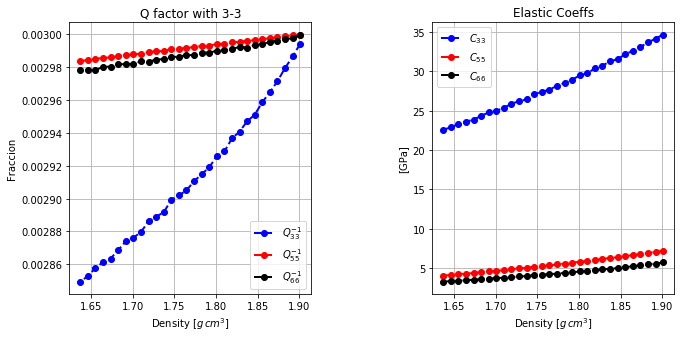

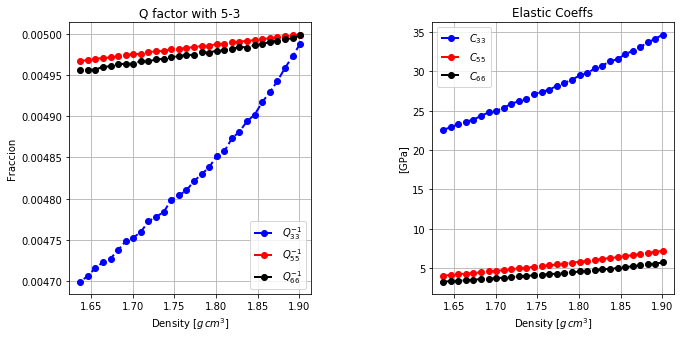

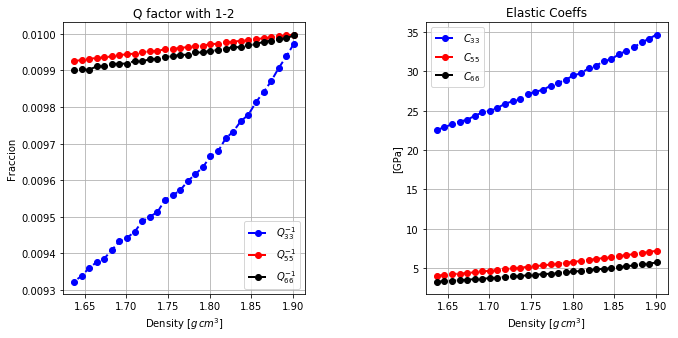

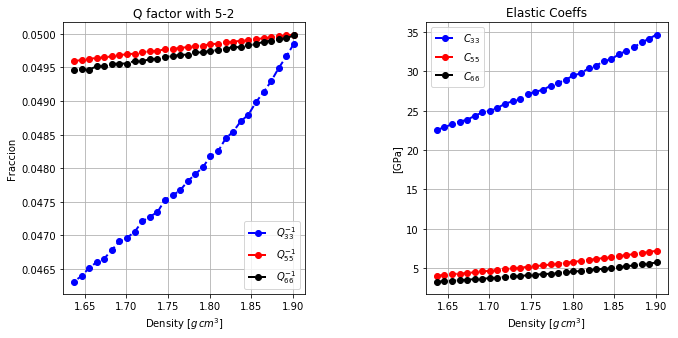

In [24]:
for att in ['3-3', '5-3', '1-2', '5-2']:
    filename = 'DataPICKLE/Visc_'+str(structure) \
               +'2DPart'+str(part)+'EPS'+str(att) \
               +'_Ome'+str(omega)+'.pickle'
    with open(filename, 'rb') as handle:
        data_saved = pickle.load(handle)
    fig, ax = QFactorPlot(data_saved, att)

### Multiple Frequency Plot

In [12]:
def QFactorCurves(freqs, eps_factor):
    # Create the plot figure
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    fig.subplots_adjust(left=0.2, wspace=0.5)

    # Obtain the mesh partition, fixed!
    part = 50
    # Iterate over the files
    #d_rev = d[::-1]
    # Define legend 
    legend_name = []
    for freq in freqs:
        filename = 'DataPICKLE/Visc_'+str(structure)+ \
                   '2DPart'+str(part)+'EPS'+eps_factor+ \
                   '_Ome'+str(freq)+'.pickle'
        legend_name.append('$f=$'+str(freq)+'[MHz]')
        with open(filename, 'rb') as handle:
            data_saved = pickle.load(handle)
        # plot the case of Inverse Q_33
        IQ_33 = np.array(data_saved['D33'])/\
                np.array(data_saved['C33'])
        ax[0].plot(d, IQ_33, 'o--' ,linewidth=2)
        # Now, for the case inverse Q_44 = Q_55
        IQ_55 = np.array(data_saved['D55'])/\
                np.array(data_saved['C55'])
        ax[1].plot(d, IQ_55, 'o--', linewidth=2)
        # Finally, case of inverse Q_66
        IQ_66 = np.array(data_saved['D66'])/\
                np.array(data_saved['C66'])
        ax[2].plot(d, IQ_66, 'o--', linewidth=2)

    # Add more formating to the plot.
    # set ylabel at each case
    ax[0].set_ylabel('Frac. Level')
    ax[1].set_ylabel('Frac. Level')
    ax[2].set_ylabel('Frac. Level')
    # Mark the other options for the figure
    ax[0].set_xlabel('Density $[g\, cm^{-3}]$')
    ax[1].set_xlabel('Density $[g\, cm^{-3}]$')
    ax[2].set_xlabel('Density $[g\, cm^{-3}]$')
    # Give titles to the plots
    ax[0].set_title('$Q_{33}(f)$ factors')
    ax[1].set_title('$Q_{55}(f)$ factors')
    ax[2].set_title('$Q_{66}(f)$ factors')
    
    # Add legend
    ax[0].legend(legend_name, 
                 loc='best')
    ax[1].legend(legend_name, 
                 loc='best')
    ax[2].legend(legend_name, 
                 loc='best')
    
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    # save it!
    filename = 'Plots/QfactorsFreqsEPS'+str(eps_factor)
    # show plot
    for _ in ['.pdf', '.png']:
        plt.savefig(filename+_, dpi=200, bbox_inches='tight')
        plt.savefig(filename+_, dpi=200, bbox_inches='tight')

    plt.show()
    return fig, ax

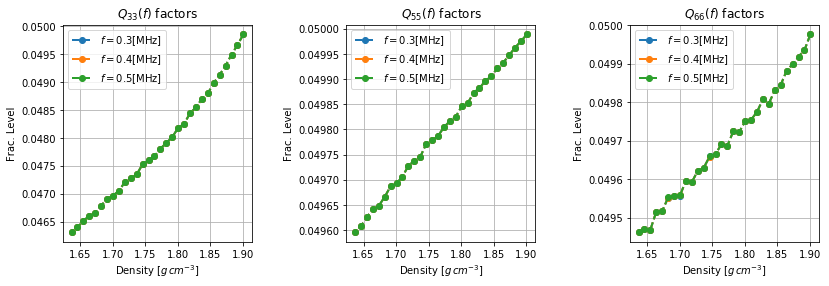

In [13]:
freq_array = [n/10 for n in range(3, 6)]
fig, ax = QFactorCurves(freq_array, eps_factor='5-2')